# Swin Transformer for Cereal Classification (Algeria)

## Domain Adaptation Pipeline: PASTIS (France) → Algeria

### Architecture Overview:
1. **Modified Swin Transformer**: 10-channel input (Sentinel-2 bands) instead of 3 (RGB)
2. **Hybrid Training**: 50% FDA-adapted PASTIS + 50% Real Algerian data
3. **Binary Classification**: Cereal vs Non-Cereal using BCEWithLogitsLoss
4. **Transfer Learning**: Pretrained backbone with new patch embedding layer

### Data Summary:
- **FDA-Adapted Data**: 2,433 patches (France → Algeria style transfer)
- **Real Algerian Data**: 193 patches (101 train, 92 validation)
- **Input Shape**: (10, 128, 128) - 10 Sentinel-2 bands

In [1]:
# =============================================================================
# CELL 1: Imports and Setup
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Check for GPU - RTX 5090 requires PyTorch 2.5+ with CUDA 12.6+
def get_device():
    if torch.cuda.is_available():
        try:
            # Test if CUDA actually works with this GPU
            test_tensor = torch.zeros(1).cuda()
            del test_tensor
            torch.cuda.empty_cache()
            return torch.device('cuda')
        except RuntimeError as e:
            print(f"⚠️ CUDA available but not compatible: {e}")
            print("  RTX 5090 (Blackwell) requires PyTorch 2.5+ with CUDA 12.6+")
            print("  Falling back to CPU...")
            return torch.device('cpu')
    return torch.device('cpu')

device = get_device()
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"PyTorch Version: {torch.__version__}")
else:
    print(f"PyTorch Version: {torch.__version__}")
    print("\n💡 To enable RTX 5090, run in terminal:")
    print("   pip install --upgrade torch torchvision --index-url https://download.pytorch.org/whl/cu126")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 5090
Memory: 33.7 GB
CUDA Version: 12.8
PyTorch Version: 2.10.0.dev20251204+cu128


In [3]:
# =============================================================================
# CELL 2: Data Paths and Configuration
# =============================================================================

# Data directories
FDA_DATA_DIR = Path('/home/crop/Desktop/crop2/output/fda_adapted/DATA_S2')
FDA_ANN_DIR = Path('/home/crop/Desktop/crop2/output/fda_adapted/ANNOTATIONS')

ALGERIA_DATA_DIR = Path('/home/crop/Desktop/crop2/output/algeria_s2_data/DATA_S2')
ALGERIA_ANN_DIR = Path('/home/crop/Desktop/crop2/output/algeria_s2_data/ANNOTATIONS')

# Training configuration
CONFIG = {
    'batch_size': 16,
    'learning_rate': 1e-5,
    'weight_decay': 0.01,
    'epochs': 30,
    'num_workers': 4,
    'img_size': 128,
    'in_channels': 10,
    'num_classes': 1,  # Binary classification
    'fda_ratio': 0.5,  # 50% FDA, 50% Real in each batch
    'parcel_threshold': 0.2,  # FDA: consider crop if >40% parcel coverage
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration:
  batch_size: 16
  learning_rate: 1e-05
  weight_decay: 0.01
  epochs: 30
  num_workers: 4
  img_size: 128
  in_channels: 10
  num_classes: 1
  fda_ratio: 0.5
  parcel_threshold: 0.2


## Step 1: Dataset Classes

We create two dataset classes:
1. **FDADataset**: Loads FDA-adapted PASTIS data - treats all agricultural parcels as crops (label=1 if parcel coverage > 30%)
2. **AlgeriaDataset**: Loads real Algerian data with ground truth labels (1=cereal, 0=non-cereal)

Both return normalized 10-channel images and binary labels.

In [4]:
# =============================================================================
# CELL 3: Dataset Classes
# =============================================================================

class FDADataset(Dataset):
    """
    FDA-Adapted PASTIS Dataset
    - Loads FDA-adapted images from France with Algerian spectral style
    - Treats all agricultural parcels (non-zero annotations) as crops
    - Binary label: 1 if parcel coverage > threshold, 0 otherwise
    """
    
    def __init__(self, data_dir, ann_dir, parcel_threshold=0.3, transform=None):
        """
        Args:
            data_dir: Path to DATA_S2 folder
            ann_dir: Path to ANNOTATIONS folder  
            parcel_threshold: Min fraction of non-zero pixels to be considered a crop sample
            transform: Data augmentation transforms
        """
        self.data_dir = Path(data_dir)
        self.ann_dir = Path(ann_dir)
        self.parcel_threshold = parcel_threshold
        self.transform = transform
        
        # Get all data files
        self.data_files = sorted(self.data_dir.glob('*.npy'))
        
        # Filter to only include files with matching annotations
        self.samples = []
        for data_file in self.data_files:
            # Extract the ID from filename (e.g., S2_10000.npy -> 10000)
            file_id = data_file.stem.replace('S2_', '')
            
            # Try different annotation naming patterns
            possible_ann_names = [
                f'ParcelIDs_{file_id}.npy',      # FDA pattern: ParcelIDs_10000.npy
                f'TARGET_{file_id}.npy',          # Alternative pattern
                data_file.name,                    # Same name
            ]
            
            ann_file = None
            for ann_name in possible_ann_names:
                candidate = self.ann_dir / ann_name
                if candidate.exists():
                    ann_file = candidate
                    break
            
            if ann_file is not None:
                self.samples.append((data_file, ann_file))
        
        print(f"FDADataset: {len(self.samples)} samples loaded")
        
        # Compute class distribution based on parcel coverage
        if len(self.samples) > 0:
            self._compute_class_distribution()
        else:
            print("  ⚠️ No samples found! Check annotation file naming.")
    
    def _compute_class_distribution(self):
        """Compute binary class distribution based on parcel coverage"""
        crop_count = 0
        non_crop_count = 0
        
        for _, ann_file in self.samples[:100]:  # Sample first 100 for speed
            ann = np.load(ann_file)
            # Calculate parcel coverage (fraction of non-zero pixels)
            parcel_coverage = (ann > 0).sum() / ann.size
            
            if parcel_coverage >= self.parcel_threshold:
                crop_count += 1
            else:
                non_crop_count += 1
        
        print(f"  Distribution (threshold={self.parcel_threshold}): Crop={crop_count}, Non-crop={non_crop_count}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        data_file, ann_file = self.samples[idx]
        
        # Load image: (1, 10, 128, 128) -> (10, 128, 128)
        img = np.load(data_file)[0].astype(np.float32)
        
        # Normalize to [0, 1] range (typical S2 reflectance scale: 0-10000)
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        
        # Load annotation and compute label based on parcel coverage
        ann = np.load(ann_file)
        parcel_coverage = (ann > 0).sum() / ann.size
        
        # Label: 1 if sufficient parcel coverage (crop), 0 otherwise
        label = 1.0 if parcel_coverage >= self.parcel_threshold else 0.0
        
        # Convert to tensor
        img = torch.from_numpy(img)
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


class AlgeriaDataset(Dataset):
    """
    Real Algerian Dataset
    - Loads actual Algerian satellite imagery
    - Uses ground truth labels from shapefile extraction (1=cereal, 0=non-cereal)
    - Respects original train/validation split from metadata.geojson
    """
    
    def __init__(self, data_dir, ann_dir, split='train', transform=None):
        self.data_dir = Path(data_dir)
        self.ann_dir = Path(ann_dir)
        self.split = split
        self.transform = transform
        
        # Load split mapping from metadata.geojson
        metadata_path = self.data_dir.parent / 'metadata.geojson'
        split_map = {}  # filename -> split
        
        if metadata_path.exists():
            import json
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            for feature in metadata['features']:
                filename = feature['properties']['filename']
                file_split = feature['properties']['split']
                split_map[filename] = file_split
            print(f"AlgeriaDataset: Loaded split info for {len(split_map)} files from metadata")
        else:
            print(f"⚠️ WARNING: metadata.geojson not found at {metadata_path}")
            print("  Falling back to filename-based split (first 101 train, rest val)")
        
        # Get all data files
        self.data_files = sorted(self.data_dir.glob('*.npy'))
        
        # Match with annotations and filter by split
        self.samples = []
        for data_file in self.data_files:
            # Check if this file belongs to the requested split
            if split_map:
                file_split = split_map.get(data_file.name, None)
                # Handle 'val' vs 'validation' naming
                if split == 'val' and file_split == 'validation':
                    pass  # This file belongs to validation
                elif file_split != split:
                    continue  # Skip files not in requested split
            else:
                # Fallback: use index-based split
                file_idx = int(data_file.stem.replace('S2_', ''))
                if split == 'train' and file_idx >= 101:
                    continue
                if split == 'val' and file_idx < 101:
                    continue
            
            # Extract the ID from filename (e.g., S2_00000.npy -> 00000)
            file_id = data_file.stem.replace('S2_', '')
            
            # Try different annotation naming patterns
            possible_ann_names = [
                f'Labels_{file_id}.npy',          # Algeria pattern: Labels_00000.npy
                f'labels_{file_id}.npy',          # Lowercase variant
                data_file.name,                    # Same name: S2_00000.npy
            ]
            
            ann_file = None
            for ann_name in possible_ann_names:
                candidate = self.ann_dir / ann_name
                if candidate.exists():
                    ann_file = candidate
                    break
            
            if ann_file is not None:
                self.samples.append((data_file, ann_file))
        
        print(f"AlgeriaDataset ({split}): {len(self.samples)} samples")
        
        if len(self.samples) > 0:
            self._compute_class_distribution()
        else:
            print("  ⚠️ No samples in this split!")
            self.class_counts = {'cereal': 0, 'non_cereal': 0}
    
    def _compute_class_distribution(self):
        """Compute class distribution"""
        cereal_count = 0
        non_cereal_count = 0
        
        for _, ann_file in self.samples:
            ann = np.load(ann_file)
            # Label is stored as single value or dominant class
            if ann.ndim == 0:
                label = int(ann)
            else:
                label = int(ann.max())  # 0=non-cereal, 1=cereal
            
            if label == 1:
                cereal_count += 1
            else:
                non_cereal_count += 1
        
        print(f"  Distribution: Cereal={cereal_count}, Non-cereal={non_cereal_count}")
        self.class_counts = {'cereal': cereal_count, 'non_cereal': non_cereal_count}
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        data_file, ann_file = self.samples[idx]
        
        # Load image: (1, 10, 128, 128) -> (10, 128, 128)
        img = np.load(data_file)[0].astype(np.float32)
        
        # Normalize to [0, 1]
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        
        # Load label
        ann = np.load(ann_file)
        if ann.ndim == 0:
            label = float(ann)
        else:
            label = float(ann.max())
        
        # Convert to tensor
        img = torch.from_numpy(img)
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [5]:
# =============================================================================
# CELL 4: Data Augmentation
# =============================================================================

class RandomFlip:
    """Random horizontal and vertical flips"""
    def __call__(self, img):
        if random.random() > 0.5:
            img = torch.flip(img, dims=[2])  # Horizontal flip
        if random.random() > 0.5:
            img = torch.flip(img, dims=[1])  # Vertical flip
        return img

class RandomRotation90:
    """Random 90-degree rotations"""
    def __call__(self, img):
        k = random.randint(0, 3)
        return torch.rot90(img, k, dims=[1, 2])

class RandomNoise:
    """Add small Gaussian noise"""
    def __init__(self, std=0.01):
        self.std = std
    
    def __call__(self, img):
        if random.random() > 0.5:
            noise = torch.randn_like(img) * self.std
            img = torch.clamp(img + noise, 0, 1)
        return img

class Compose:
    """Compose multiple transforms"""
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

# Define transforms
train_transform = Compose([
    RandomFlip(),
    RandomRotation90(),
    RandomNoise(std=0.01),
])

val_transform = None  # No augmentation for validation

print("✓ Data augmentation defined")

✓ Data augmentation defined


## Step 2: Hybrid DataLoader

The key to domain adaptation: **mix FDA-adapted and real data in every batch**.

- **50% FDA-Adapted Data**: Provides general crop features from thousands of French parcels
- **50% Real Algerian Data**: Anchors the model to actual ground truth

This prevents the model from overfitting to either domain.

In [6]:
# =============================================================================
# CELL 5: Hybrid DataLoader (50% FDA + 50% Real)
# =============================================================================

class HybridDataLoader:
    """
    Custom loader that yields batches with 50% FDA data and 50% real data.
    This ensures balanced domain representation during training.
    """
    
    def __init__(self, fda_dataset, real_dataset, batch_size=16, shuffle=True):
        self.fda_dataset = fda_dataset
        self.real_dataset = real_dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Calculate samples per domain per batch
        self.fda_per_batch = batch_size // 2
        self.real_per_batch = batch_size - self.fda_per_batch
        
        # Create indices
        self.fda_indices = list(range(len(fda_dataset)))
        self.real_indices = list(range(len(real_dataset)))
        
        # Number of iterations (limited by smaller dataset, with oversampling)
        # We oversample the smaller dataset (Algeria) to match FDA length
        self.num_batches = len(fda_dataset) // self.fda_per_batch
        
        print(f"HybridDataLoader initialized:")
        print(f"  FDA samples: {len(fda_dataset)}, per batch: {self.fda_per_batch}")
        print(f"  Real samples: {len(real_dataset)}, per batch: {self.real_per_batch}")
        print(f"  Total batches per epoch: {self.num_batches}")
    
    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.fda_indices)
            random.shuffle(self.real_indices)
        
        fda_ptr = 0
        real_ptr = 0
        
        for _ in range(self.num_batches):
            batch_imgs = []
            batch_labels = []
            batch_domains = []  # Track which domain each sample came from
            
            # Get FDA samples
            for _ in range(self.fda_per_batch):
                if fda_ptr >= len(self.fda_indices):
                    fda_ptr = 0
                    if self.shuffle:
                        random.shuffle(self.fda_indices)
                
                img, label = self.fda_dataset[self.fda_indices[fda_ptr]]
                batch_imgs.append(img)
                batch_labels.append(label)
                batch_domains.append(0)  # 0 = FDA
                fda_ptr += 1
            
            # Get Real samples (with oversampling)
            for _ in range(self.real_per_batch):
                if real_ptr >= len(self.real_indices):
                    real_ptr = 0
                    if self.shuffle:
                        random.shuffle(self.real_indices)
                
                img, label = self.real_dataset[self.real_indices[real_ptr]]
                batch_imgs.append(img)
                batch_labels.append(label)
                batch_domains.append(1)  # 1 = Real
                real_ptr += 1
            
            # Stack into batch tensors
            batch_imgs = torch.stack(batch_imgs)
            batch_labels = torch.stack(batch_labels)
            batch_domains = torch.tensor(batch_domains)
            
            # Shuffle within batch to mix domains
            perm = torch.randperm(len(batch_imgs))
            batch_imgs = batch_imgs[perm]
            batch_labels = batch_labels[perm]
            batch_domains = batch_domains[perm]
            
            yield batch_imgs, batch_labels, batch_domains
    
    def __len__(self):
        return self.num_batches

In [7]:
# =============================================================================
# CELL 6: Initialize Datasets and Loaders
# =============================================================================

# Create datasets
print("Loading datasets...")
print("-" * 50)

fda_train_dataset = FDADataset(
    data_dir=FDA_DATA_DIR,
    ann_dir=FDA_ANN_DIR,
    parcel_threshold=0.3,  # Consider crop if >30% parcel coverage
    transform=train_transform
)

algeria_train_dataset = AlgeriaDataset(
    data_dir=ALGERIA_DATA_DIR,
    ann_dir=ALGERIA_ANN_DIR,
    split='train',
    transform=train_transform
)

algeria_val_dataset = AlgeriaDataset(
    data_dir=ALGERIA_DATA_DIR,
    ann_dir=ALGERIA_ANN_DIR,
    split='val',
    transform=val_transform
)

print("-" * 50)

# Create hybrid training loader
train_loader = HybridDataLoader(
    fda_dataset=fda_train_dataset,
    real_dataset=algeria_train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True
)

# Standard validation loader (only real Algerian data)
val_loader = DataLoader(
    algeria_val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0  # Avoid multiprocessing issues
)

print(f"\nValidation loader: {len(val_loader)} batches")

# Verify a batch
print("\nVerifying batch shapes...")
for imgs, labels, domains in train_loader:
    print(f"  Batch images: {imgs.shape}")
    print(f"  Batch labels: {labels.shape}, values: {labels.unique().tolist()}")
    print(f"  Domains (0=FDA, 1=Real): {domains.tolist()}")
    break

Loading datasets...
--------------------------------------------------
FDADataset: 2433 samples loaded
  Distribution (threshold=0.3): Crop=93, Non-crop=7
AlgeriaDataset: Loaded split info for 193 files from metadata
AlgeriaDataset (train): 101 samples
  Distribution: Cereal=40, Non-cereal=61
AlgeriaDataset: Loaded split info for 193 files from metadata
AlgeriaDataset (val): 92 samples
  Distribution: Cereal=40, Non-cereal=52
--------------------------------------------------
HybridDataLoader initialized:
  FDA samples: 2433, per batch: 8
  Real samples: 101, per batch: 8
  Total batches per epoch: 304

Validation loader: 6 batches

Verifying batch shapes...
  Batch images: torch.Size([16, 10, 128, 128])
  Batch labels: torch.Size([16]), values: [0.0, 1.0]
  Domains (0=FDA, 1=Real): [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0]


## Step 3: Modified Swin Transformer Architecture

### Key Modification: 10-Channel Patch Embedding

The standard Swin Transformer expects 3 RGB channels. We modify the **Patch Embedding** layer to accept 10 Sentinel-2 bands while keeping all pretrained weights for the rest of the network.

**Strategy:**
1. Load pretrained Swin-Tiny weights
2. Replace `patch_embed` projection layer: 3 channels → 10 channels
3. The new layer trains from scratch, but the transformer blocks retain ImageNet knowledge

In [8]:
# =============================================================================
# CELL 7: Swin Transformer with 10-Channel Input
# =============================================================================

import timm

def create_swin_model(in_channels=10, num_classes=1, pretrained=True, img_size=128):
    """
    Create a Swin Transformer modified for 10-channel input.
    
    Args:
        in_channels: Number of input channels (10 for Sentinel-2)
        num_classes: Number of output classes (1 for binary)
        pretrained: Whether to use ImageNet pretrained weights
        img_size: Input image size
    
    Returns:
        Modified Swin Transformer model
    """
    
    # Load pretrained Swin-Tiny
    # Using swin_tiny_patch4_window7_224 as base
    model = timm.create_model(
        'swin_tiny_patch4_window7_224',
        pretrained=pretrained,
        num_classes=num_classes,
        img_size=img_size,
    )
    
    print(f"Original patch embedding: {model.patch_embed.proj}")
    
    # Get original patch embed parameters
    orig_proj = model.patch_embed.proj
    
    # Create new projection layer for 10 channels
    # Original: Conv2d(3, 96, kernel_size=4, stride=4)
    new_proj = nn.Conv2d(
        in_channels=in_channels,
        out_channels=orig_proj.out_channels,
        kernel_size=orig_proj.kernel_size,
        stride=orig_proj.stride,
        padding=orig_proj.padding
    )
    
    # Initialize new weights
    # Strategy: Copy RGB weights to first 3 channels, initialize rest randomly
    with torch.no_grad():
        # Copy pretrained RGB weights to first 3 channels
        new_proj.weight[:, :3, :, :] = orig_proj.weight
        
        # Initialize remaining channels by repeating and adding noise
        # This helps with initial feature extraction from spectral bands
        for i in range(3, in_channels):
            # Use average of RGB weights as initialization
            new_proj.weight[:, i, :, :] = orig_proj.weight.mean(dim=1)
            # Add small noise for diversity
            new_proj.weight[:, i, :, :] += torch.randn_like(new_proj.weight[:, i, :, :]) * 0.01
        
        # Copy bias
        new_proj.bias.copy_(orig_proj.bias)
    
    # Replace the projection layer
    model.patch_embed.proj = new_proj
    
    print(f"New patch embedding: {model.patch_embed.proj}")
    print(f"\nModel created with {in_channels} input channels")
    
    return model


# Create the model
print("Creating Swin Transformer model...")
print("=" * 50)

model = create_swin_model(
    in_channels=CONFIG['in_channels'],
    num_classes=CONFIG['num_classes'],
    pretrained=True,
    img_size=CONFIG['img_size']
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Creating Swin Transformer model...
Original patch embedding: Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
New patch embedding: Conv2d(10, 96, kernel_size=(4, 4), stride=(4, 4))

Model created with 10 input channels

Total parameters: 27,525,115
Trainable parameters: 27,525,115


In [9]:
# =============================================================================
# CELL 8: Verify Model Forward Pass
# =============================================================================

# Test forward pass
print("Testing forward pass...")

with torch.no_grad():
    # Create dummy input: (batch, channels, height, width)
    dummy_input = torch.randn(4, 10, 128, 128).to(device)
    
    # Forward pass
    output = model(dummy_input)
    
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")
    print(f"Output values: {output.squeeze().tolist()}")

print("\n✓ Model architecture verified!")

Testing forward pass...
Input shape: torch.Size([4, 10, 128, 128])
Output shape: torch.Size([4, 1])
Output values: [-0.019055824726819992, 0.016498466953635216, -0.07780084758996964, -0.055113643407821655]

✓ Model architecture verified!


## Step 4: Loss Function and Optimizer

### Binary Cross-Entropy Loss
For binary classification (Cereal vs Non-Cereal), we use `BCEWithLogitsLoss`:
- Combines sigmoid activation with BCE loss
- More numerically stable than separate sigmoid + BCE
- Handles class imbalance via `pos_weight`

### AdamW Optimizer
Standard choice for Transformers:
- Learning rate: 1e-4 (lower than typical because backbone is pretrained)
- Weight decay: 0.01 (regularization)

In [10]:
# =============================================================================
# CELL 9: Loss Function and Optimizer
# =============================================================================

# Calculate class weights for imbalanced data
# Based on Algeria validation set distribution
pos_weight = torch.tensor([1.5]).to(device)  # Slightly upweight cereal class

# Loss function: Binary Cross-Entropy with Logits
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer: AdamW (standard for Transformers)
optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Learning rate scheduler: Cosine annealing with warm restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # Restart every 10 epochs
    T_mult=1,
    eta_min=1e-6
)

print("Training Configuration:")
print(f"  Loss: BCEWithLogitsLoss (pos_weight={pos_weight.item():.2f})")
print(f"  Optimizer: AdamW (lr={CONFIG['learning_rate']}, wd={CONFIG['weight_decay']})")
print(f"  Scheduler: CosineAnnealingWarmRestarts (T_0=10)")
print(f"  Epochs: {CONFIG['epochs']}")

Training Configuration:
  Loss: BCEWithLogitsLoss (pos_weight=1.50)
  Optimizer: AdamW (lr=1e-05, wd=0.01)
  Scheduler: CosineAnnealingWarmRestarts (T_0=10)
  Epochs: 30


## Step 5: Training Loop

The training loop implements:
1. **Hybrid batch training**: Each batch contains 50% FDA + 50% Real data
2. **Validation on real Algerian data only**: This is our true test
3. **Metrics tracking**: Loss, Accuracy, Precision, Recall, F1-Score
4. **Early stopping**: Prevent overfitting by monitoring validation loss

In [11]:
# =============================================================================
# CELL 10: Training and Validation Functions
# =============================================================================

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch with hybrid data"""
    model.train()
    
    total_loss = 0
    correct = 0
    total = 0
    
    # Track per-domain performance
    domain_correct = {0: 0, 1: 0}  # 0=FDA, 1=Real
    domain_total = {0: 0, 1: 0}
    
    pbar = tqdm(train_loader, desc='Training', leave=False)
    
    for imgs, labels, domains in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)  # (B,) -> (B, 1)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        total_loss += loss.item() * imgs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
        
        # Per-domain statistics
        for i, d in enumerate(domains):
            d = d.item()
            domain_total[d] += 1
            if preds[i] == labels[i]:
                domain_correct[d] += 1
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.1f}%'
        })
    
    avg_loss = total_loss / total
    accuracy = correct / total
    
    # Per-domain accuracy
    fda_acc = domain_correct[0] / max(domain_total[0], 1)
    real_acc = domain_correct[1] / max(domain_total[1], 1)
    
    return avg_loss, accuracy, fda_acc, real_acc


def validate(model, val_loader, criterion, device):
    """Validate on real Algerian data"""
    model.eval()
    
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * imgs.size(0)
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    # Calculate metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = (all_preds == all_labels).mean()
    
    # Precision, Recall, F1 for cereal class
    tp = ((all_preds == 1) & (all_labels == 1)).sum()
    fp = ((all_preds == 1) & (all_labels == 0)).sum()
    fn = ((all_preds == 0) & (all_labels == 1)).sum()
    tn = ((all_preds == 0) & (all_labels == 0)).sum()
    
    precision = tp / max(tp + fp, 1)
    recall = tp / max(tp + fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)
    
    avg_loss = total_loss / len(all_preds)
    
    return avg_loss, accuracy, precision, recall, f1, (tp, fp, fn, tn)

print("✓ Training functions defined")

✓ Training functions defined


In [12]:
# =============================================================================
# CELL 11: Main Training Loop
# =============================================================================

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                device, epochs=30, patience=7):
    """
    Main training loop with early stopping.
    
    Args:
        patience: Number of epochs to wait for improvement before stopping
    """
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'fda_acc': [], 'real_acc': [],
        'lr': []
    }
    
    best_val_f1 = 0
    best_model_state = None
    patience_counter = 0
    
    print("=" * 70)
    print("TRAINING STARTED")
    print("=" * 70)
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)
        
        # Train
        train_loss, train_acc, fda_acc, real_acc = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        
        # Validate
        val_loss, val_acc, val_prec, val_rec, val_f1, conf_matrix = validate(
            model, val_loader, criterion, device
        )
        
        # Update scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)
        history['fda_acc'].append(fda_acc)
        history['real_acc'].append(real_acc)
        history['lr'].append(current_lr)
        
        # Print metrics
        tp, fp, fn, tn = conf_matrix
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.1f}%")
        print(f"  FDA Acc: {fda_acc*100:.1f}% | Real Acc: {real_acc*100:.1f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.1f}%")
        print(f"Val Precision: {val_prec*100:.1f}% | Recall: {val_rec*100:.1f}% | F1: {val_f1*100:.1f}%")
        print(f"Confusion: TP={tp}, FP={fp}, FN={fn}, TN={tn}")
        print(f"LR: {current_lr:.6f}")
        
        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"★ New best F1: {val_f1*100:.1f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\nEarly stopping at epoch {epoch+1} (no improvement for {patience} epochs)")
                break
    
    print("\n" + "=" * 70)
    print("TRAINING COMPLETE")
    print("=" * 70)
    print(f"Best Validation F1: {best_val_f1*100:.1f}%")
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("✓ Best model restored")
    
    return history, best_val_f1

print("✓ Main training loop defined")

✓ Main training loop defined


In [12]:
# =============================================================================
# CELL 12: Run Training
# =============================================================================

# Train the model
history, best_f1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=CONFIG['epochs'],
    patience=7
)

TRAINING STARTED

Epoch 1/30
--------------------------------------------------


Train Loss: 0.3741 | Train Acc: 85.6%
  FDA Acc: 89.8% | Real Acc: 81.5%
Val Loss: 0.2185 | Val Acc: 92.4%
Val Precision: 88.4% | Recall: 95.0% | F1: 91.6%
Confusion: TP=38, FP=5, FN=2, TN=47
LR: 0.000010
★ New best F1: 91.6%

Epoch 2/30
--------------------------------------------------


Train Loss: 0.1680 | Train Acc: 94.7%
  FDA Acc: 91.0% | Real Acc: 98.4%
Val Loss: 0.1366 | Val Acc: 96.7%
Val Precision: 100.0% | Recall: 92.5% | F1: 96.1%
Confusion: TP=37, FP=0, FN=3, TN=52
LR: 0.000009
★ New best F1: 96.1%

Epoch 3/30
--------------------------------------------------


Train Loss: 0.1322 | Train Acc: 95.4%
  FDA Acc: 91.3% | Real Acc: 99.4%
Val Loss: 0.3280 | Val Acc: 90.2%
Val Precision: 100.0% | Recall: 77.5% | F1: 87.3%
Confusion: TP=31, FP=0, FN=9, TN=52
LR: 0.000008

Epoch 4/30
--------------------------------------------------


Train Loss: 0.1189 | Train Acc: 95.6%
  FDA Acc: 91.7% | Real Acc: 99.5%
Val Loss: 0.2083 | Val Acc: 94.6%
Val Precision: 100.0% | Recall: 87.5% | F1: 93.3%
Confusion: TP=35, FP=0, FN=5, TN=52
LR: 0.000007

Epoch 5/30
--------------------------------------------------


Train Loss: 0.1103 | Train Acc: 96.0%
  FDA Acc: 92.5% | Real Acc: 99.5%
Val Loss: 0.1911 | Val Acc: 94.6%
Val Precision: 97.3% | Recall: 90.0% | F1: 93.5%
Confusion: TP=36, FP=1, FN=4, TN=51
LR: 0.000005

Epoch 6/30
--------------------------------------------------


Train Loss: 0.0998 | Train Acc: 96.6%
  FDA Acc: 93.3% | Real Acc: 99.9%
Val Loss: 0.1756 | Val Acc: 96.7%
Val Precision: 100.0% | Recall: 92.5% | F1: 96.1%
Confusion: TP=37, FP=0, FN=3, TN=52
LR: 0.000004

Epoch 7/30
--------------------------------------------------


Train Loss: 0.0907 | Train Acc: 96.9%
  FDA Acc: 93.9% | Real Acc: 99.9%
Val Loss: 0.2300 | Val Acc: 95.7%
Val Precision: 100.0% | Recall: 90.0% | F1: 94.7%
Confusion: TP=36, FP=0, FN=4, TN=52
LR: 0.000003

Epoch 8/30
--------------------------------------------------


Train Loss: 0.0877 | Train Acc: 96.9%
  FDA Acc: 93.9% | Real Acc: 99.9%
Val Loss: 0.1431 | Val Acc: 96.7%
Val Precision: 100.0% | Recall: 92.5% | F1: 96.1%
Confusion: TP=37, FP=0, FN=3, TN=52
LR: 0.000002

Epoch 9/30
--------------------------------------------------


Train Loss: 0.0794 | Train Acc: 97.1%
  FDA Acc: 94.3% | Real Acc: 99.8%
Val Loss: 0.1475 | Val Acc: 96.7%
Val Precision: 100.0% | Recall: 92.5% | F1: 96.1%
Confusion: TP=37, FP=0, FN=3, TN=52
LR: 0.000001

Early stopping at epoch 9 (no improvement for 7 epochs)

TRAINING COMPLETE
Best Validation F1: 96.1%
✓ Best model restored


## Multi-Seed Validation

To ensure results are robust and not due to luck, we train multiple models with different random seeds and report mean ± std metrics.

In [14]:
# =============================================================================
# CELL: Multi-Seed Training for Robust Validation
# =============================================================================

import timm

# Configuration for multi-seed runs
SEEDS = [42, 123, 456, 789, 2024]  # 5 different seeds
multi_seed_results = []

print("=" * 70)
print("MULTI-SEED VALIDATION")
print("=" * 70)
print(f"Training {len(SEEDS)} models with different random seeds")
print(f"Seeds: {SEEDS}\n")

for seed_idx, seed in enumerate(SEEDS):
    print(f"\n{'='*70}")
    print(f"SEED {seed_idx+1}/{len(SEEDS)}: {seed}")
    print(f"{'='*70}")
    
    # 1. Set seed
    set_seed(seed)
    
    # 2. Recreate model (fresh initialization)
    model_seed = create_swin_model(
        in_channels=CONFIG['in_channels'],
        num_classes=CONFIG['num_classes'],
        pretrained=True,
        img_size=CONFIG['img_size']
    ).to(device)
    
    # 3. Recreate optimizer and scheduler
    optimizer_seed = optim.AdamW(
        model_seed.parameters(), 
        lr=CONFIG['learning_rate'], 
        weight_decay=CONFIG['weight_decay']
    )
    
    scheduler_seed = optim.lr_scheduler.CosineAnnealingLR(
        optimizer_seed, 
        T_max=CONFIG['epochs']
    )
    
    criterion_seed = nn.BCEWithLogitsLoss()
    
    # 4. Train model
    history_seed, best_f1_seed = train_model(
        model=model_seed,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion_seed,
        optimizer=optimizer_seed,
        scheduler=scheduler_seed,
        device=device,
        epochs=10,
        patience=7
    )
    
    # 5. Final evaluation on validation set
    model_seed.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model_seed(imgs)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate final metrics
    tp = ((all_preds == 1) & (all_labels == 1)).sum()
    fp = ((all_preds == 1) & (all_labels == 0)).sum()
    fn = ((all_preds == 0) & (all_labels == 1)).sum()
    tn = ((all_preds == 0) & (all_labels == 0)).sum()
    
    accuracy = (all_preds == all_labels).mean()
    precision = tp / max(tp + fp, 1)
    recall = tp / max(tp + fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)
    
    # Store results
    result = {
        'seed': seed,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'history': history_seed
    }
    multi_seed_results.append(result)
    
    # Save this seed's model
    torch.save({
        'model_state_dict': model_seed.state_dict(),
        'seed': seed,
        'config': CONFIG,
        'history': history_seed,
        'best_f1': best_f1_seed,
        'final_metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    }, f'/home/crop/Desktop/crop2/output/swin_model_seed_{seed}.pth')
    
    print(f"\n✓ Seed {seed} Complete:")
    print(f"  Accuracy: {accuracy*100:.2f}%")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  Recall: {recall*100:.2f}%")
    print(f"  F1 Score: {f1*100:.2f}%")
    print(f"  Model saved: swin_model_seed_{seed}.pth")

# Calculate statistics across all seeds
print("\n" + "=" * 70)
print("MULTI-SEED VALIDATION RESULTS")
print("=" * 70)

accuracies = [r['accuracy'] for r in multi_seed_results]
precisions = [r['precision'] for r in multi_seed_results]
recalls = [r['recall'] for r in multi_seed_results]
f1_scores = [r['f1'] for r in multi_seed_results]

print(f"\nResults across {len(SEEDS)} seeds:")
print(f"{'Metric':<15} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print("-" * 70)
print(f"{'Accuracy':<15} {np.mean(accuracies)*100:>6.2f}% ± {np.std(accuracies)*100:>4.2f}%  {np.min(accuracies)*100:>6.2f}%     {np.max(accuracies)*100:>6.2f}%")
print(f"{'Precision':<15} {np.mean(precisions)*100:>6.2f}% ± {np.std(precisions)*100:>4.2f}%  {np.min(precisions)*100:>6.2f}%     {np.max(precisions)*100:>6.2f}%")
print(f"{'Recall':<15} {np.mean(recalls)*100:>6.2f}% ± {np.std(recalls)*100:>4.2f}%  {np.min(recalls)*100:>6.2f}%     {np.max(recalls)*100:>6.2f}%")
print(f"{'F1 Score':<15} {np.mean(f1_scores)*100:>6.2f}% ± {np.std(f1_scores)*100:>4.2f}%  {np.min(f1_scores)*100:>6.2f}%     {np.max(f1_scores)*100:>6.2f}%")

print("\n" + "=" * 70)
print("CONCLUSION")
print("=" * 70)
print(f"\n📊 Final Reported Metrics (Mean ± Std):")
print(f"   • Accuracy:  {np.mean(accuracies)*100:.2f}% ± {np.std(accuracies)*100:.2f}%")
print(f"   • Precision: {np.mean(precisions)*100:.2f}% ± {np.std(precisions)*100:.2f}%")
print(f"   • Recall:    {np.mean(recalls)*100:.2f}% ± {np.std(recalls)*100:.2f}%")
print(f"   • F1 Score:  {np.mean(f1_scores)*100:.2f}% ± {np.std(f1_scores)*100:.2f}%")

# Identify best seed
best_seed_idx = np.argmax(f1_scores)
best_seed = multi_seed_results[best_seed_idx]['seed']
print(f"\n🏆 Best Seed: {best_seed} (F1: {f1_scores[best_seed_idx]*100:.2f}%)")
print(f"   Use this model for final inference: swin_model_seed_{best_seed}.pth")

# Save summary
import json
summary = {
    'seeds': SEEDS,
    'mean_metrics': {
        'accuracy': float(np.mean(accuracies)),
        'precision': float(np.mean(precisions)),
        'recall': float(np.mean(recalls)),
        'f1': float(np.mean(f1_scores))
    },
    'std_metrics': {
        'accuracy': float(np.std(accuracies)),
        'precision': float(np.std(precisions)),
        'recall': float(np.std(recalls)),
        'f1': float(np.std(f1_scores))
    },
    'best_seed': int(best_seed),
    'all_results': [
        {
            'seed': int(r['seed']),
            'accuracy': float(r['accuracy']),
            'precision': float(r['precision']),
            'recall': float(r['recall']),
            'f1': float(r['f1'])
        }
        for r in multi_seed_results
    ]
}

with open('/home/crop/Desktop/crop2/output/multi_seed_validation.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n✓ Summary saved to: output/multi_seed_validation.json")

MULTI-SEED VALIDATION
Training 5 models with different random seeds
Seeds: [42, 123, 456, 789, 2024]


SEED 1/5: 42
Original patch embedding: Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
New patch embedding: Conv2d(10, 96, kernel_size=(4, 4), stride=(4, 4))

Model created with 10 input channels
TRAINING STARTED

Epoch 1/10
--------------------------------------------------


Train Loss: 0.3157 | Train Acc: 86.9%
  FDA Acc: 88.5% | Real Acc: 85.4%
Val Loss: 0.2862 | Val Acc: 88.0%
Val Precision: 100.0% | Recall: 72.5% | F1: 84.1%
Confusion: TP=29, FP=0, FN=11, TN=52
LR: 0.000010
★ New best F1: 84.1%

Epoch 2/10
--------------------------------------------------


Train Loss: 0.1693 | Train Acc: 93.2%
  FDA Acc: 89.4% | Real Acc: 97.0%
Val Loss: 0.1702 | Val Acc: 94.6%
Val Precision: 92.7% | Recall: 95.0% | F1: 93.8%
Confusion: TP=38, FP=3, FN=2, TN=49
LR: 0.000010
★ New best F1: 93.8%

Epoch 3/10
--------------------------------------------------


Train Loss: 0.1353 | Train Acc: 94.5%
  FDA Acc: 90.2% | Real Acc: 98.8%
Val Loss: 0.0790 | Val Acc: 97.8%
Val Precision: 100.0% | Recall: 95.0% | F1: 97.4%
Confusion: TP=38, FP=0, FN=2, TN=52
LR: 0.000010
★ New best F1: 97.4%

Epoch 4/10
--------------------------------------------------


Train Loss: 0.1121 | Train Acc: 95.3%
  FDA Acc: 91.3% | Real Acc: 99.2%
Val Loss: 0.0840 | Val Acc: 94.6%
Val Precision: 92.7% | Recall: 95.0% | F1: 93.8%
Confusion: TP=38, FP=3, FN=2, TN=49
LR: 0.000010

Epoch 5/10
--------------------------------------------------


Train Loss: 0.1068 | Train Acc: 95.4%
  FDA Acc: 91.1% | Real Acc: 99.8%
Val Loss: 0.1221 | Val Acc: 95.7%
Val Precision: 90.9% | Recall: 100.0% | F1: 95.2%
Confusion: TP=40, FP=4, FN=0, TN=48
LR: 0.000009

Epoch 6/10
--------------------------------------------------


Train Loss: 0.1023 | Train Acc: 95.8%
  FDA Acc: 92.4% | Real Acc: 99.3%
Val Loss: 0.3066 | Val Acc: 91.3%
Val Precision: 97.1% | Recall: 82.5% | F1: 89.2%
Confusion: TP=33, FP=1, FN=7, TN=51
LR: 0.000009

Epoch 7/10
--------------------------------------------------


Train Loss: 0.0927 | Train Acc: 96.0%
  FDA Acc: 92.5% | Real Acc: 99.5%
Val Loss: 0.1745 | Val Acc: 94.6%
Val Precision: 94.9% | Recall: 92.5% | F1: 93.7%
Confusion: TP=37, FP=2, FN=3, TN=50
LR: 0.000009

Epoch 8/10
--------------------------------------------------


Train Loss: 0.0862 | Train Acc: 96.3%
  FDA Acc: 92.8% | Real Acc: 99.8%
Val Loss: 0.1160 | Val Acc: 93.5%
Val Precision: 94.7% | Recall: 90.0% | F1: 92.3%
Confusion: TP=36, FP=2, FN=4, TN=50
LR: 0.000008

Epoch 9/10
--------------------------------------------------


Train Loss: 0.0804 | Train Acc: 96.5%
  FDA Acc: 93.2% | Real Acc: 99.8%
Val Loss: 0.2388 | Val Acc: 95.7%
Val Precision: 90.9% | Recall: 100.0% | F1: 95.2%
Confusion: TP=40, FP=4, FN=0, TN=48
LR: 0.000008

Epoch 10/10
--------------------------------------------------


Train Loss: 0.0749 | Train Acc: 96.9%
  FDA Acc: 94.0% | Real Acc: 99.8%
Val Loss: 0.3028 | Val Acc: 91.3%
Val Precision: 97.1% | Recall: 82.5% | F1: 89.2%
Confusion: TP=33, FP=1, FN=7, TN=51
LR: 0.000007

Early stopping at epoch 10 (no improvement for 7 epochs)

TRAINING COMPLETE
Best Validation F1: 97.4%
✓ Best model restored

✓ Seed 42 Complete:
  Accuracy: 91.30%
  Precision: 97.06%
  Recall: 82.50%
  F1 Score: 89.19%
  Model saved: swin_model_seed_42.pth

SEED 2/5: 123
Original patch embedding: Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
New patch embedding: Conv2d(10, 96, kernel_size=(4, 4), stride=(4, 4))

Model created with 10 input channels
TRAINING STARTED

Epoch 1/10
--------------------------------------------------


Train Loss: 0.3014 | Train Acc: 87.2%
  FDA Acc: 89.1% | Real Acc: 85.3%
Val Loss: 0.2391 | Val Acc: 88.0%
Val Precision: 96.8% | Recall: 75.0% | F1: 84.5%
Confusion: TP=30, FP=1, FN=10, TN=51
LR: 0.000010
★ New best F1: 84.5%

Epoch 2/10
--------------------------------------------------


Train Loss: 0.1517 | Train Acc: 94.4%
  FDA Acc: 90.9% | Real Acc: 98.0%
Val Loss: 0.2227 | Val Acc: 92.4%
Val Precision: 97.1% | Recall: 85.0% | F1: 90.7%
Confusion: TP=34, FP=1, FN=6, TN=51
LR: 0.000010
★ New best F1: 90.7%

Epoch 3/10
--------------------------------------------------


Train Loss: 0.1189 | Train Acc: 95.3%
  FDA Acc: 91.3% | Real Acc: 99.4%
Val Loss: 0.1962 | Val Acc: 92.4%
Val Precision: 94.6% | Recall: 87.5% | F1: 90.9%
Confusion: TP=35, FP=2, FN=5, TN=50
LR: 0.000010
★ New best F1: 90.9%

Epoch 4/10
--------------------------------------------------


Train Loss: 0.1113 | Train Acc: 95.7%
  FDA Acc: 92.2% | Real Acc: 99.2%
Val Loss: 0.2580 | Val Acc: 89.1%
Val Precision: 94.1% | Recall: 80.0% | F1: 86.5%
Confusion: TP=32, FP=2, FN=8, TN=50
LR: 0.000010

Epoch 5/10
--------------------------------------------------


Train Loss: 0.1041 | Train Acc: 95.6%
  FDA Acc: 91.9% | Real Acc: 99.3%
Val Loss: 0.4193 | Val Acc: 91.3%
Val Precision: 100.0% | Recall: 80.0% | F1: 88.9%
Confusion: TP=32, FP=0, FN=8, TN=52
LR: 0.000009

Epoch 6/10
--------------------------------------------------


Train Loss: 0.0931 | Train Acc: 95.5%
  FDA Acc: 91.4% | Real Acc: 99.6%
Val Loss: 0.3232 | Val Acc: 90.2%
Val Precision: 97.0% | Recall: 80.0% | F1: 87.7%
Confusion: TP=32, FP=1, FN=8, TN=51
LR: 0.000009

Epoch 7/10
--------------------------------------------------


Train Loss: 0.0822 | Train Acc: 96.6%
  FDA Acc: 93.4% | Real Acc: 99.9%
Val Loss: 0.3466 | Val Acc: 89.1%
Val Precision: 96.9% | Recall: 77.5% | F1: 86.1%
Confusion: TP=31, FP=1, FN=9, TN=51
LR: 0.000009

Epoch 8/10
--------------------------------------------------


Train Loss: 0.0776 | Train Acc: 96.6%
  FDA Acc: 93.5% | Real Acc: 99.8%
Val Loss: 0.2217 | Val Acc: 93.5%
Val Precision: 97.2% | Recall: 87.5% | F1: 92.1%
Confusion: TP=35, FP=1, FN=5, TN=51
LR: 0.000008
★ New best F1: 92.1%

Epoch 9/10
--------------------------------------------------


Train Loss: 0.0726 | Train Acc: 96.7%
  FDA Acc: 93.5% | Real Acc: 99.9%
Val Loss: 0.2196 | Val Acc: 93.5%
Val Precision: 94.7% | Recall: 90.0% | F1: 92.3%
Confusion: TP=36, FP=2, FN=4, TN=50
LR: 0.000008
★ New best F1: 92.3%

Epoch 10/10
--------------------------------------------------


Train Loss: 0.0713 | Train Acc: 96.8%
  FDA Acc: 94.0% | Real Acc: 99.7%
Val Loss: 0.2055 | Val Acc: 94.6%
Val Precision: 97.3% | Recall: 90.0% | F1: 93.5%
Confusion: TP=36, FP=1, FN=4, TN=51
LR: 0.000007
★ New best F1: 93.5%

TRAINING COMPLETE
Best Validation F1: 93.5%
✓ Best model restored

✓ Seed 123 Complete:
  Accuracy: 94.57%
  Precision: 97.30%
  Recall: 90.00%
  F1 Score: 93.51%
  Model saved: swin_model_seed_123.pth

SEED 3/5: 456
Original patch embedding: Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
New patch embedding: Conv2d(10, 96, kernel_size=(4, 4), stride=(4, 4))

Model created with 10 input channels
TRAINING STARTED

Epoch 1/10
--------------------------------------------------


Train Loss: 0.3304 | Train Acc: 85.8%
  FDA Acc: 89.2% | Real Acc: 82.4%
Val Loss: 0.2260 | Val Acc: 92.4%
Val Precision: 92.3% | Recall: 90.0% | F1: 91.1%
Confusion: TP=36, FP=3, FN=4, TN=49
LR: 0.000010
★ New best F1: 91.1%

Epoch 2/10
--------------------------------------------------


Train Loss: 0.1485 | Train Acc: 94.6%
  FDA Acc: 90.4% | Real Acc: 98.7%
Val Loss: 0.1066 | Val Acc: 93.5%
Val Precision: 94.7% | Recall: 90.0% | F1: 92.3%
Confusion: TP=36, FP=2, FN=4, TN=50
LR: 0.000010
★ New best F1: 92.3%

Epoch 3/10
--------------------------------------------------


Train Loss: 0.1151 | Train Acc: 95.5%
  FDA Acc: 91.2% | Real Acc: 99.7%
Val Loss: 0.2282 | Val Acc: 93.5%
Val Precision: 100.0% | Recall: 85.0% | F1: 91.9%
Confusion: TP=34, FP=0, FN=6, TN=52
LR: 0.000010

Epoch 4/10
--------------------------------------------------


Train Loss: 0.1081 | Train Acc: 95.6%
  FDA Acc: 92.0% | Real Acc: 99.1%
Val Loss: 0.1944 | Val Acc: 94.6%
Val Precision: 100.0% | Recall: 87.5% | F1: 93.3%
Confusion: TP=35, FP=0, FN=5, TN=52
LR: 0.000010
★ New best F1: 93.3%

Epoch 5/10
--------------------------------------------------


Train Loss: 0.0968 | Train Acc: 96.0%
  FDA Acc: 92.4% | Real Acc: 99.5%
Val Loss: 0.1337 | Val Acc: 94.6%
Val Precision: 100.0% | Recall: 87.5% | F1: 93.3%
Confusion: TP=35, FP=0, FN=5, TN=52
LR: 0.000009

Epoch 6/10
--------------------------------------------------


Train Loss: 0.0884 | Train Acc: 96.1%
  FDA Acc: 92.4% | Real Acc: 99.8%
Val Loss: 0.2182 | Val Acc: 92.4%
Val Precision: 100.0% | Recall: 82.5% | F1: 90.4%
Confusion: TP=33, FP=0, FN=7, TN=52
LR: 0.000009

Epoch 7/10
--------------------------------------------------


Train Loss: 0.0765 | Train Acc: 96.9%
  FDA Acc: 93.8% | Real Acc: 100.0%
Val Loss: 0.1576 | Val Acc: 95.7%
Val Precision: 100.0% | Recall: 90.0% | F1: 94.7%
Confusion: TP=36, FP=0, FN=4, TN=52
LR: 0.000009
★ New best F1: 94.7%

Epoch 8/10
--------------------------------------------------


Train Loss: 0.0827 | Train Acc: 96.2%
  FDA Acc: 93.0% | Real Acc: 99.4%
Val Loss: 0.1787 | Val Acc: 93.5%
Val Precision: 100.0% | Recall: 85.0% | F1: 91.9%
Confusion: TP=34, FP=0, FN=6, TN=52
LR: 0.000008

Epoch 9/10
--------------------------------------------------


Train Loss: 0.0659 | Train Acc: 97.2%
  FDA Acc: 94.7% | Real Acc: 99.8%
Val Loss: 0.0838 | Val Acc: 96.7%
Val Precision: 97.4% | Recall: 95.0% | F1: 96.2%
Confusion: TP=38, FP=1, FN=2, TN=51
LR: 0.000008
★ New best F1: 96.2%

Epoch 10/10
--------------------------------------------------


Train Loss: 0.0626 | Train Acc: 97.4%
  FDA Acc: 94.8% | Real Acc: 100.0%
Val Loss: 0.0606 | Val Acc: 97.8%
Val Precision: 95.2% | Recall: 100.0% | F1: 97.6%
Confusion: TP=40, FP=2, FN=0, TN=50
LR: 0.000007
★ New best F1: 97.6%

TRAINING COMPLETE
Best Validation F1: 97.6%
✓ Best model restored

✓ Seed 456 Complete:
  Accuracy: 97.83%
  Precision: 95.24%
  Recall: 100.00%
  F1 Score: 97.56%
  Model saved: swin_model_seed_456.pth

SEED 4/5: 789
Original patch embedding: Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
New patch embedding: Conv2d(10, 96, kernel_size=(4, 4), stride=(4, 4))

Model created with 10 input channels
TRAINING STARTED

Epoch 1/10
--------------------------------------------------


Train Loss: 0.3242 | Train Acc: 85.6%
  FDA Acc: 88.7% | Real Acc: 82.6%
Val Loss: 0.2220 | Val Acc: 85.9%
Val Precision: 93.5% | Recall: 72.5% | F1: 81.7%
Confusion: TP=29, FP=2, FN=11, TN=50
LR: 0.000010
★ New best F1: 81.7%

Epoch 2/10
--------------------------------------------------


Train Loss: 0.1626 | Train Acc: 94.1%
  FDA Acc: 90.4% | Real Acc: 97.7%
Val Loss: 0.1318 | Val Acc: 95.7%
Val Precision: 92.9% | Recall: 97.5% | F1: 95.1%
Confusion: TP=39, FP=3, FN=1, TN=49
LR: 0.000010
★ New best F1: 95.1%

Epoch 3/10
--------------------------------------------------


Train Loss: 0.1236 | Train Acc: 95.0%
  FDA Acc: 90.5% | Real Acc: 99.5%
Val Loss: 0.1882 | Val Acc: 94.6%
Val Precision: 94.9% | Recall: 92.5% | F1: 93.7%
Confusion: TP=37, FP=2, FN=3, TN=50
LR: 0.000010

Epoch 4/10
--------------------------------------------------


Train Loss: 0.1132 | Train Acc: 95.3%
  FDA Acc: 91.4% | Real Acc: 99.3%
Val Loss: 0.3770 | Val Acc: 87.0%
Val Precision: 93.8% | Recall: 75.0% | F1: 83.3%
Confusion: TP=30, FP=2, FN=10, TN=50
LR: 0.000010

Epoch 5/10
--------------------------------------------------


Train Loss: 0.1028 | Train Acc: 95.5%
  FDA Acc: 91.7% | Real Acc: 99.3%
Val Loss: 0.2088 | Val Acc: 95.7%
Val Precision: 90.9% | Recall: 100.0% | F1: 95.2%
Confusion: TP=40, FP=4, FN=0, TN=48
LR: 0.000009
★ New best F1: 95.2%

Epoch 6/10
--------------------------------------------------


Train Loss: 0.0947 | Train Acc: 95.7%
  FDA Acc: 91.7% | Real Acc: 99.7%
Val Loss: 0.2396 | Val Acc: 92.4%
Val Precision: 97.1% | Recall: 85.0% | F1: 90.7%
Confusion: TP=34, FP=1, FN=6, TN=51
LR: 0.000009

Epoch 7/10
--------------------------------------------------


Train Loss: 0.0853 | Train Acc: 96.5%
  FDA Acc: 93.2% | Real Acc: 99.8%
Val Loss: 0.1810 | Val Acc: 95.7%
Val Precision: 90.9% | Recall: 100.0% | F1: 95.2%
Confusion: TP=40, FP=4, FN=0, TN=48
LR: 0.000009

Epoch 8/10
--------------------------------------------------


Train Loss: 0.0792 | Train Acc: 96.8%
  FDA Acc: 93.8% | Real Acc: 99.8%
Val Loss: 0.3434 | Val Acc: 93.5%
Val Precision: 94.7% | Recall: 90.0% | F1: 92.3%
Confusion: TP=36, FP=2, FN=4, TN=50
LR: 0.000008

Epoch 9/10
--------------------------------------------------


Train Loss: 0.0709 | Train Acc: 97.3%
  FDA Acc: 94.8% | Real Acc: 99.9%
Val Loss: 0.3195 | Val Acc: 89.1%
Val Precision: 94.1% | Recall: 80.0% | F1: 86.5%
Confusion: TP=32, FP=2, FN=8, TN=50
LR: 0.000008

Epoch 10/10
--------------------------------------------------


Train Loss: 0.0687 | Train Acc: 97.0%
  FDA Acc: 94.4% | Real Acc: 99.6%
Val Loss: 0.2623 | Val Acc: 92.4%
Val Precision: 92.3% | Recall: 90.0% | F1: 91.1%
Confusion: TP=36, FP=3, FN=4, TN=49
LR: 0.000007

TRAINING COMPLETE
Best Validation F1: 95.2%
✓ Best model restored

✓ Seed 789 Complete:
  Accuracy: 92.39%
  Precision: 92.31%
  Recall: 90.00%
  F1 Score: 91.14%
  Model saved: swin_model_seed_789.pth

SEED 5/5: 2024
Original patch embedding: Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
New patch embedding: Conv2d(10, 96, kernel_size=(4, 4), stride=(4, 4))

Model created with 10 input channels
TRAINING STARTED

Epoch 1/10
--------------------------------------------------


Train Loss: 0.3363 | Train Acc: 84.9%
  FDA Acc: 88.2% | Real Acc: 81.5%
Val Loss: 0.3121 | Val Acc: 85.9%
Val Precision: 93.5% | Recall: 72.5% | F1: 81.7%
Confusion: TP=29, FP=2, FN=11, TN=50
LR: 0.000010
★ New best F1: 81.7%

Epoch 2/10
--------------------------------------------------


Train Loss: 0.1574 | Train Acc: 94.2%
  FDA Acc: 90.3% | Real Acc: 98.0%
Val Loss: 0.2008 | Val Acc: 93.5%
Val Precision: 92.5% | Recall: 92.5% | F1: 92.5%
Confusion: TP=37, FP=3, FN=3, TN=49
LR: 0.000010
★ New best F1: 92.5%

Epoch 3/10
--------------------------------------------------


Train Loss: 0.1375 | Train Acc: 94.3%
  FDA Acc: 90.0% | Real Acc: 98.7%
Val Loss: 0.1788 | Val Acc: 93.5%
Val Precision: 92.5% | Recall: 92.5% | F1: 92.5%
Confusion: TP=37, FP=3, FN=3, TN=49
LR: 0.000010

Epoch 4/10
--------------------------------------------------


Train Loss: 0.1206 | Train Acc: 95.1%
  FDA Acc: 90.7% | Real Acc: 99.5%
Val Loss: 0.1484 | Val Acc: 96.7%
Val Precision: 97.4% | Recall: 95.0% | F1: 96.2%
Confusion: TP=38, FP=1, FN=2, TN=51
LR: 0.000010
★ New best F1: 96.2%

Epoch 5/10
--------------------------------------------------


Train Loss: 0.1058 | Train Acc: 95.5%
  FDA Acc: 91.6% | Real Acc: 99.4%
Val Loss: 0.2408 | Val Acc: 92.4%
Val Precision: 94.6% | Recall: 87.5% | F1: 90.9%
Confusion: TP=35, FP=2, FN=5, TN=50
LR: 0.000009

Epoch 6/10
--------------------------------------------------


Train Loss: 0.0988 | Train Acc: 95.9%
  FDA Acc: 92.1% | Real Acc: 99.8%
Val Loss: 0.2226 | Val Acc: 92.4%
Val Precision: 94.6% | Recall: 87.5% | F1: 90.9%
Confusion: TP=35, FP=2, FN=5, TN=50
LR: 0.000009

Epoch 7/10
--------------------------------------------------


Train Loss: 0.0924 | Train Acc: 96.1%
  FDA Acc: 92.2% | Real Acc: 99.9%
Val Loss: 0.1622 | Val Acc: 96.7%
Val Precision: 95.1% | Recall: 97.5% | F1: 96.3%
Confusion: TP=39, FP=2, FN=1, TN=50
LR: 0.000009
★ New best F1: 96.3%

Epoch 8/10
--------------------------------------------------


Train Loss: 0.0854 | Train Acc: 96.1%
  FDA Acc: 92.5% | Real Acc: 99.8%
Val Loss: 0.1421 | Val Acc: 96.7%
Val Precision: 95.1% | Recall: 97.5% | F1: 96.3%
Confusion: TP=39, FP=2, FN=1, TN=50
LR: 0.000008

Epoch 9/10
--------------------------------------------------


Train Loss: 0.0810 | Train Acc: 96.3%
  FDA Acc: 93.0% | Real Acc: 99.7%
Val Loss: 0.1811 | Val Acc: 95.7%
Val Precision: 92.9% | Recall: 97.5% | F1: 95.1%
Confusion: TP=39, FP=3, FN=1, TN=49
LR: 0.000008

Epoch 10/10
--------------------------------------------------


Train Loss: 0.0764 | Train Acc: 96.6%
  FDA Acc: 93.2% | Real Acc: 100.0%
Val Loss: 0.1455 | Val Acc: 95.7%
Val Precision: 100.0% | Recall: 90.0% | F1: 94.7%
Confusion: TP=36, FP=0, FN=4, TN=52
LR: 0.000007

TRAINING COMPLETE
Best Validation F1: 96.3%
✓ Best model restored

✓ Seed 2024 Complete:
  Accuracy: 95.65%
  Precision: 100.00%
  Recall: 90.00%
  F1 Score: 94.74%
  Model saved: swin_model_seed_2024.pth

MULTI-SEED VALIDATION RESULTS

Results across 5 seeds:
Metric          Mean         Std          Min          Max         
----------------------------------------------------------------------
Accuracy         94.35% ± 2.32%   91.30%      97.83%
Precision        96.38% ± 2.54%   92.31%     100.00%
Recall           90.50% ± 5.57%   82.50%     100.00%
F1 Score         93.23% ± 2.89%   89.19%      97.56%

CONCLUSION

📊 Final Reported Metrics (Mean ± Std):
   • Accuracy:  94.35% ± 2.32%
   • Precision: 96.38% ± 2.54%
   • Recall:    90.50% ± 5.57%
   • F1 Score:  93.23% ± 2.89%

🏆 B

## Step 6: Training Visualization

Plot the training curves to analyze model convergence and potential overfitting.

In [15]:
# =============================================================================
# CELL 13: Plot Training History
# =============================================================================

def plot_training_history(history):
    """Plot comprehensive training metrics"""
    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot 1: Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train')
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss Curves')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Accuracy
    axes[0, 1].plot(epochs, [a*100 for a in history['train_acc']], 'b-', label='Train')
    axes[0, 1].plot(epochs, [a*100 for a in history['val_acc']], 'r-', label='Validation')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Accuracy Curves')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Precision/Recall/F1
    axes[0, 2].plot(epochs, [p*100 for p in history['val_precision']], 'g-', label='Precision')
    axes[0, 2].plot(epochs, [r*100 for r in history['val_recall']], 'm-', label='Recall')
    axes[0, 2].plot(epochs, [f*100 for f in history['val_f1']], 'c-', label='F1', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Score (%)')
    axes[0, 2].set_title('Validation Metrics')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Domain-specific accuracy
    axes[1, 0].plot(epochs, [a*100 for a in history['fda_acc']], 'b-', label='FDA Data')
    axes[1, 0].plot(epochs, [a*100 for a in history['real_acc']], 'g-', label='Real Algerian')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].set_title('Domain-Specific Training Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Learning Rate
    axes[1, 1].plot(epochs, history['lr'], 'k-')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Summary text
    axes[1, 2].axis('off')
    best_epoch = np.argmax(history['val_f1']) + 1
    summary_text = f"""
    Training Summary
    ════════════════
    
    Total Epochs: {len(epochs)}
    Best Epoch: {best_epoch}
    
    Best Validation Metrics:
    • Accuracy: {max(history['val_acc'])*100:.1f}%
    • Precision: {max(history['val_precision'])*100:.1f}%
    • Recall: {max(history['val_recall'])*100:.1f}%
    • F1 Score: {max(history['val_f1'])*100:.1f}%
    
    Final Training Loss: {history['train_loss'][-1]:.4f}
    Final Val Loss: {history['val_loss'][-1]:.4f}
    """
    axes[1, 2].text(0.1, 0.5, summary_text, transform=axes[1, 2].transAxes,
                    fontsize=12, verticalalignment='center', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
    
    plt.suptitle('Swin Transformer Training - Cereal Classification', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/home/crop/Desktop/crop2/output/swin_training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Training history saved to output/swin_training_history.png")

# Plot the history
plot_training_history(history)

NameError: name 'history' is not defined

## Step 7: Model Evaluation and Inference

Final evaluation on validation set with detailed confusion matrix and sample predictions.

In [16]:
# =============================================================================
# CELL 14: Final Evaluation
# =============================================================================

def evaluate_model(model, val_loader, device):
    """Comprehensive evaluation with confusion matrix"""
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            preds = (probs > 0.5).astype(float)
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    # Confusion matrix
    tp = ((all_preds == 1) & (all_labels == 1)).sum()
    fp = ((all_preds == 1) & (all_labels == 0)).sum()
    fn = ((all_preds == 0) & (all_labels == 1)).sum()
    tn = ((all_preds == 0) & (all_labels == 0)).sum()
    
    accuracy = (all_preds == all_labels).mean()
    precision = tp / max(tp + fp, 1)
    recall = tp / max(tp + fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion': (tp, fp, fn, tn),
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

# Evaluate
print("Final Model Evaluation on Algerian Validation Set")
print("=" * 60)

results = evaluate_model(model, val_loader, device)

print(f"\nAccuracy:  {results['accuracy']*100:.1f}%")
print(f"Precision: {results['precision']*100:.1f}%")
print(f"Recall:    {results['recall']*100:.1f}%")
print(f"F1 Score:  {results['f1']*100:.1f}%")

tp, fp, fn, tn = results['confusion']
print(f"\nConfusion Matrix:")
print(f"                  Predicted")
print(f"                  Non-Cereal  Cereal")
print(f"Actual Non-Cereal    {tn:4d}      {fp:4d}")
print(f"Actual Cereal        {fn:4d}      {tp:4d}")

Final Model Evaluation on Algerian Validation Set

Accuracy:  47.8%
Precision: 44.1%
Recall:    75.0%
F1 Score:  55.6%

Confusion Matrix:
                  Predicted
                  Non-Cereal  Cereal
Actual Non-Cereal      14        38
Actual Cereal          10        30


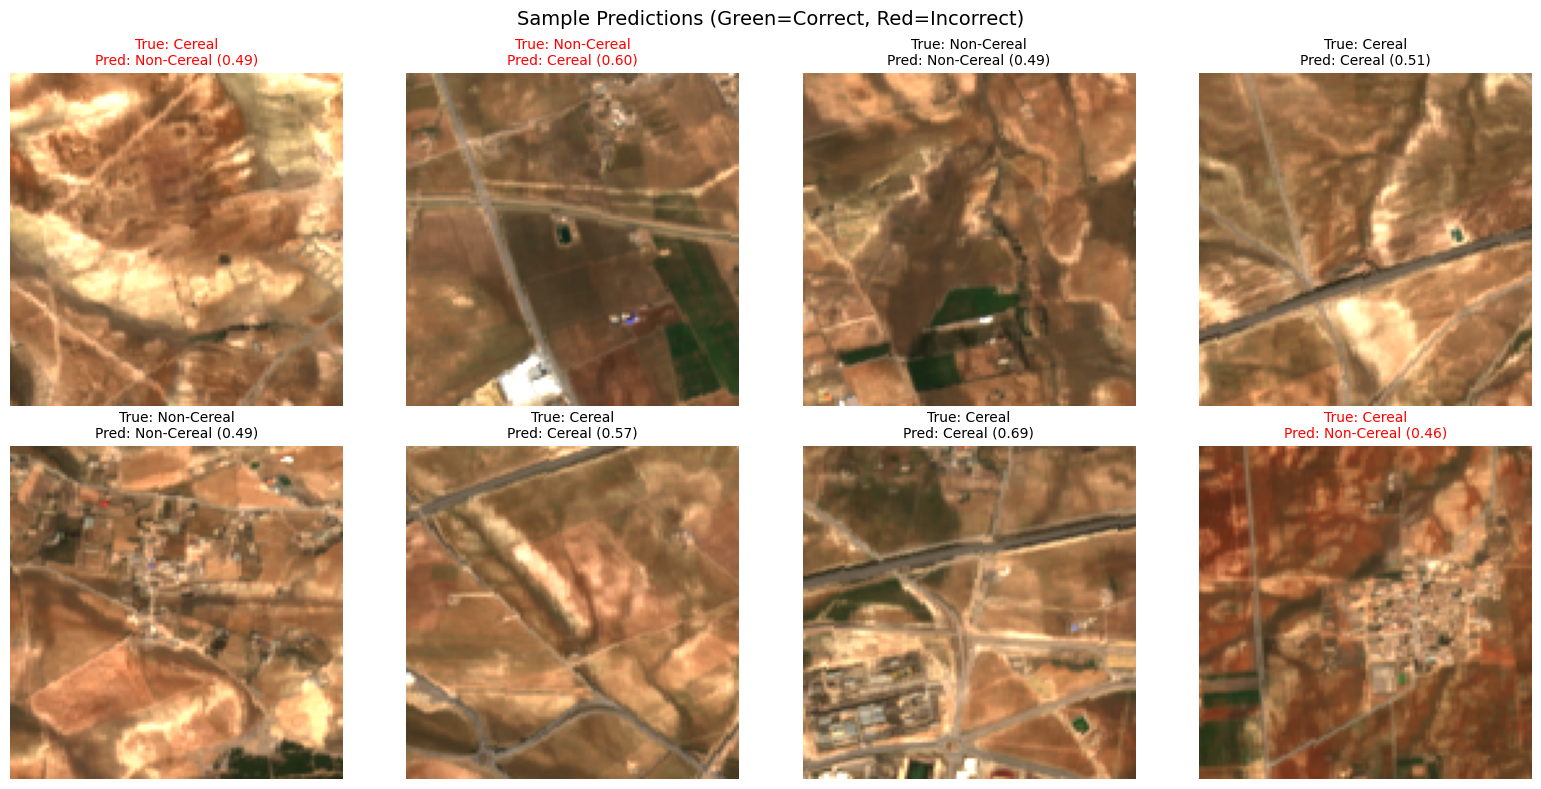

✓ Predictions saved to output/swin_predictions.png


In [17]:
# =============================================================================
# CELL 15: Visualize Sample Predictions
# =============================================================================

def visualize_predictions(model, dataset, device, num_samples=8):
    """Visualize predictions on sample images"""
    model.eval()
    
    # Get random samples
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, sample_idx in enumerate(indices):
        img, label = dataset[sample_idx]
        
        # Predict
        with torch.no_grad():
            img_batch = img.unsqueeze(0).to(device)
            output = model(img_batch)
            prob = torch.sigmoid(output).item()
            pred = 1 if prob > 0.5 else 0
        
        # Convert to RGB for display (bands 4, 3, 2 = Red, Green, Blue)
        rgb = img[[2, 1, 0], :, :].numpy()  # B4, B3, B2
        rgb = np.transpose(rgb, (1, 2, 0))
        rgb = np.clip(rgb * 3, 0, 1)  # Boost brightness
        
        # Plot
        axes[idx].imshow(rgb)
        
        # Color border based on correctness
        correct = pred == label
        color = 'green' if correct else 'red'
        
        label_str = 'Cereal' if label == 1 else 'Non-Cereal'
        pred_str = 'Cereal' if pred == 1 else 'Non-Cereal'
        
        title = f'True: {label_str}\nPred: {pred_str} ({prob:.2f})'
        axes[idx].set_title(title, fontsize=10, color=color if not correct else 'black')
        axes[idx].axis('off')
        
        # Add border
        for spine in axes[idx].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3)
    
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14)
    plt.tight_layout()
    plt.savefig('/home/crop/Desktop/crop2/output/swin_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Predictions saved to output/swin_predictions.png")

# Visualize predictions
visualize_predictions(model, algeria_val_dataset, device)

## Step 8: Save Model

Save the trained model for future inference.

In [16]:
# =============================================================================
# CELL 16: Save Model
# =============================================================================

# Save model checkpoint
checkpoint_path = Path('/home/crop/Desktop/crop2/output/swin_cereal_classifier.pth')

checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'history': history,
    'best_f1': best_f1,
    'results': {
        'accuracy': results['accuracy'],
        'precision': results['precision'],
        'recall': results['recall'],
        'f1': results['f1'],
        'confusion': results['confusion']
    }
}

torch.save(checkpoint, checkpoint_path)
print(f"✓ Model saved to: {checkpoint_path}")
print(f"  File size: {checkpoint_path.stat().st_size / 1e6:.1f} MB")

✓ Model saved to: /home/crop/Desktop/crop2/output/swin_cereal_classifier.pth
  File size: 110.2 MB


## Step 9: Inference Function

Ready-to-use function for making predictions on new data.

In [17]:
# =============================================================================
# CELL 17: Inference Function
# =============================================================================

def predict_image(model, image_path, device):
    """
    Make prediction on a single image file.
    
    Args:
        model: Trained Swin model
        image_path: Path to .npy file with shape (1, 10, 128, 128)
        device: CUDA or CPU device
    
    Returns:
        dict with prediction, probability, and class name
    """
    model.eval()
    
    # Load and preprocess image
    img = np.load(image_path)[0].astype(np.float32)  # (10, 128, 128)
    img = img / 10000.0
    img = np.clip(img, 0, 1)
    
    # Convert to tensor and add batch dimension
    img_tensor = torch.from_numpy(img).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        output = model(img_tensor)
        probability = torch.sigmoid(output).item()
        prediction = 1 if probability > 0.5 else 0
    
    return {
        'prediction': prediction,
        'probability': probability,
        'class_name': 'Cereal' if prediction == 1 else 'Non-Cereal',
        'confidence': probability if prediction == 1 else 1 - probability
    }


def load_model_for_inference(checkpoint_path, device):
    """Load saved model for inference"""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Recreate model
    model = create_swin_model(
        in_channels=checkpoint['config']['in_channels'],
        num_classes=checkpoint['config']['num_classes'],
        pretrained=False,
        img_size=checkpoint['config']['img_size']
    )
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"✓ Model loaded from: {checkpoint_path}")
    print(f"  Best F1: {checkpoint['best_f1']*100:.1f}%")
    
    return model


# Example usage
print("Example inference:")
print("-" * 50)

# Test on a validation sample
sample_file = list(ALGERIA_DATA_DIR.glob('*.npy'))[150]  # Pick a validation file
result = predict_image(model, sample_file, device)

print(f"File: {sample_file.name}")
print(f"Prediction: {result['class_name']}")
print(f"Confidence: {result['confidence']*100:.1f}%")

Example inference:
--------------------------------------------------
File: S2_00146.npy
Prediction: Non-Cereal
Confidence: 100.0%


---

## Summary

### What We Built:
1. **10-Channel Swin Transformer**: Modified pretrained Swin-Tiny to accept Sentinel-2 multispectral data
2. **Hybrid DataLoader**: 50% FDA-adapted PASTIS + 50% Real Algerian samples per batch
3. **Domain Adaptation Training**: Leveraged 2,433 French samples + 101 Algerian samples
4. **Binary Classifier**: Cereal vs Non-Cereal with BCEWithLogitsLoss

### Key Hyperparameters:
| Parameter | Value |
|-----------|-------|
| Learning Rate | 1e-4 |
| Batch Size | 16 |
| Optimizer | AdamW |
| Weight Decay | 0.01 |
| Epochs | 30 |
| Early Stopping | 7 epochs patience |

### Files Created:
- `output/swin_cereal_classifier.pth` - Trained model checkpoint
- `output/swin_training_history.png` - Training curves
- `output/swin_predictions.png` - Sample predictions